# Importing Needed Libraries

In [22]:
# import system libs
import os
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings('ignore')

# **Data Preprocessing**

### **Read data and store it in dataframe**

In [3]:
# Generate data paths with labels
train_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= "filepaths")
Lseries = pd.Series(labels, name= "labels")
train_df = pd.concat([Fseries, Lseries], axis=1)

In [4]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [5]:
# Generate data paths with labels
test_data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= "filepaths")
Lseries = pd.Series(labels, name= "labels")
tst_df = pd.concat([Fseries, Lseries], axis=1)

In [6]:
tst_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


### **Split dataframe into train, valid, and test**

In [7]:
# valid and test dataframe
valid_df, test_df = train_test_split(tst_df, shuffle=True, test_size= .5, random_state= 123)

In [8]:
test_df

,filepaths,labels
569,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
822,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1056,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
84,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
560,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
...,...,...
692,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1032,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1044,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
237,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


### **Create image data generator**

In [27]:
# crobed image size
batch_size = 16
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


### **Show sample from train data**

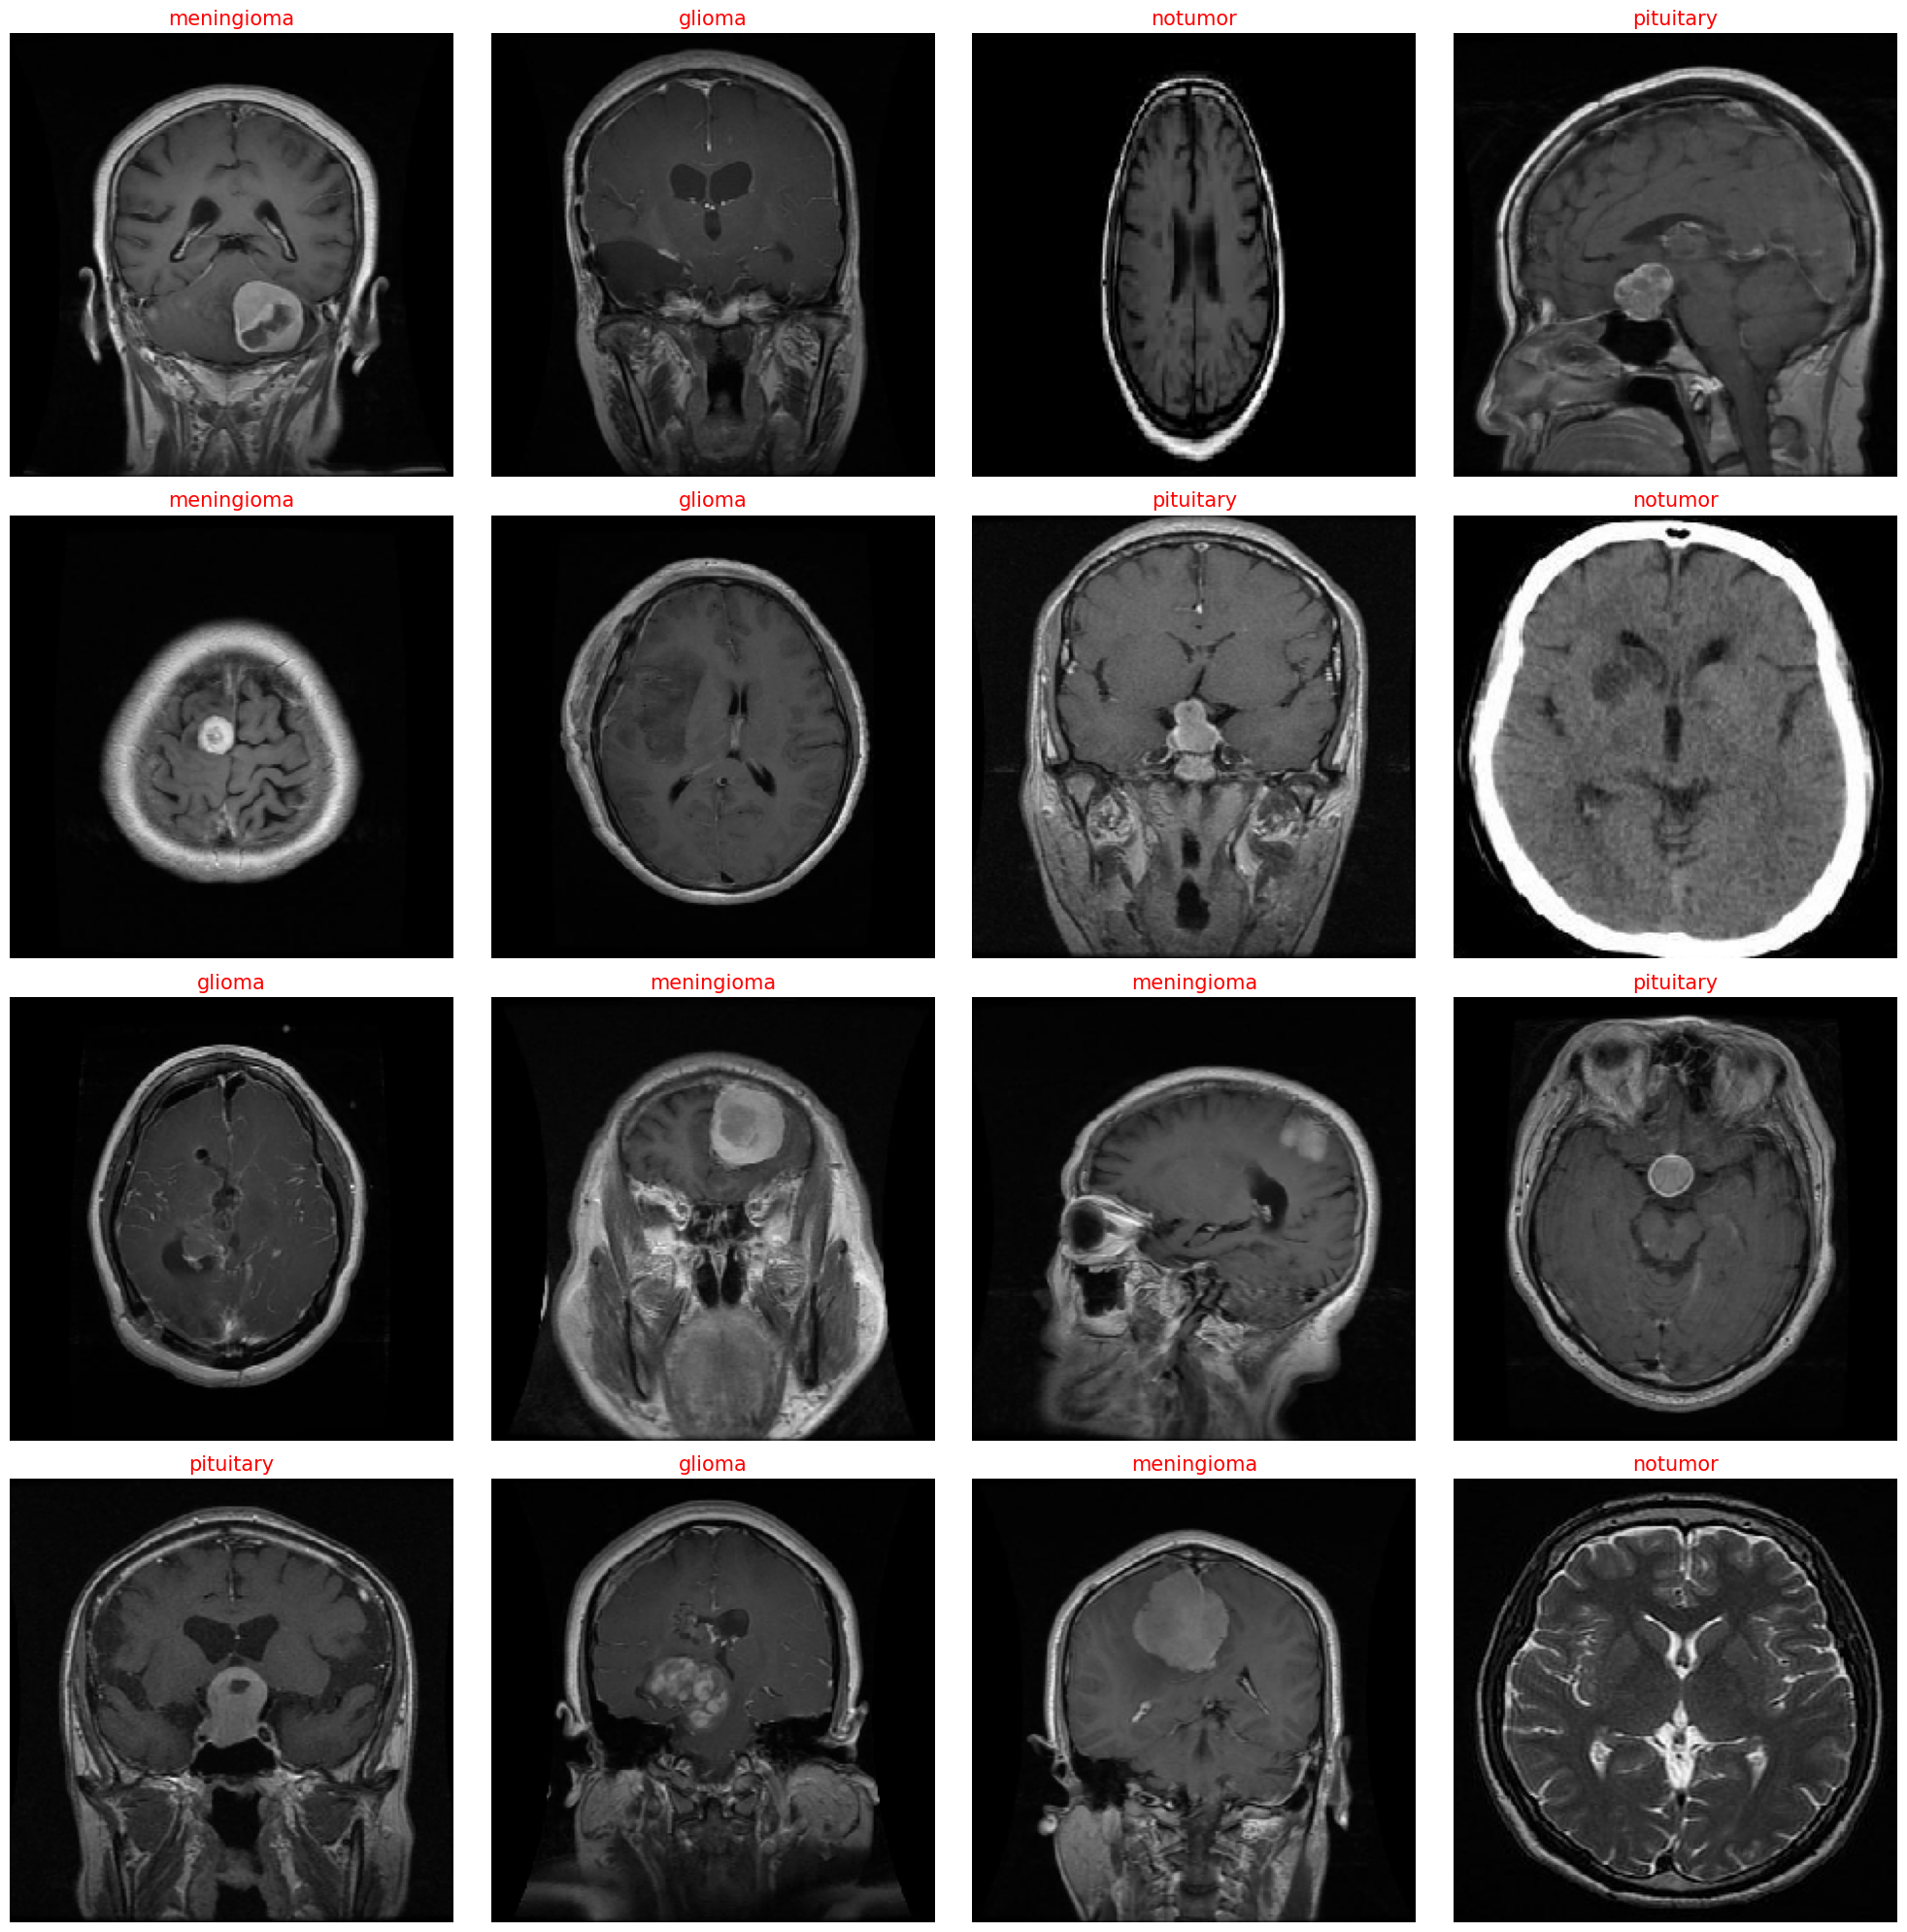

In [20]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4, 4 , i+1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'red', fontsize= 15)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [45]:
# Create Model Structure
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


model = Sequential([
    Conv2D(filters= 64, kernel_size=(3,3), activation= 'relu', padding='same', input_shape= img_shape),
    Conv2D(filters= 64, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters= 128, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 128, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters= 256, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 256, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 256, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(256, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= .0001), loss = 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,180 (80.70 MB)

 Trainable params: 21,154,180 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

#### **Train model**

In [46]:
epochs = 10   # number of all epochs in training
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 47s 117ms/step - accuracy: 0.5538 - loss: 1.0033 - val_accuracy: 0.7084 - val_loss: 0.6624
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.8131 - loss: 0.4791 - val_accuracy: 0.7634 - val_loss: 0.6187
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.8685 - loss: 0.3458 - val_accuracy: 0.8412 - val_loss: 0.4190
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.9178 - loss: 0.2275 - val_accuracy: 0.8947 - val_loss: 0.2967
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.9386 - loss: 0.1705 - val_accuracy: 0.9130 - val_loss: 0.2702
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9623 - loss: 0.1099 - val_accuracy: 0.9450 - val_loss: 0.1406
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.9752 - loss: 0.0737 - val_accuracy: 0.9450 - val_loss: 0.1699
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.9842 - loss: 0

#### **Display model performance**

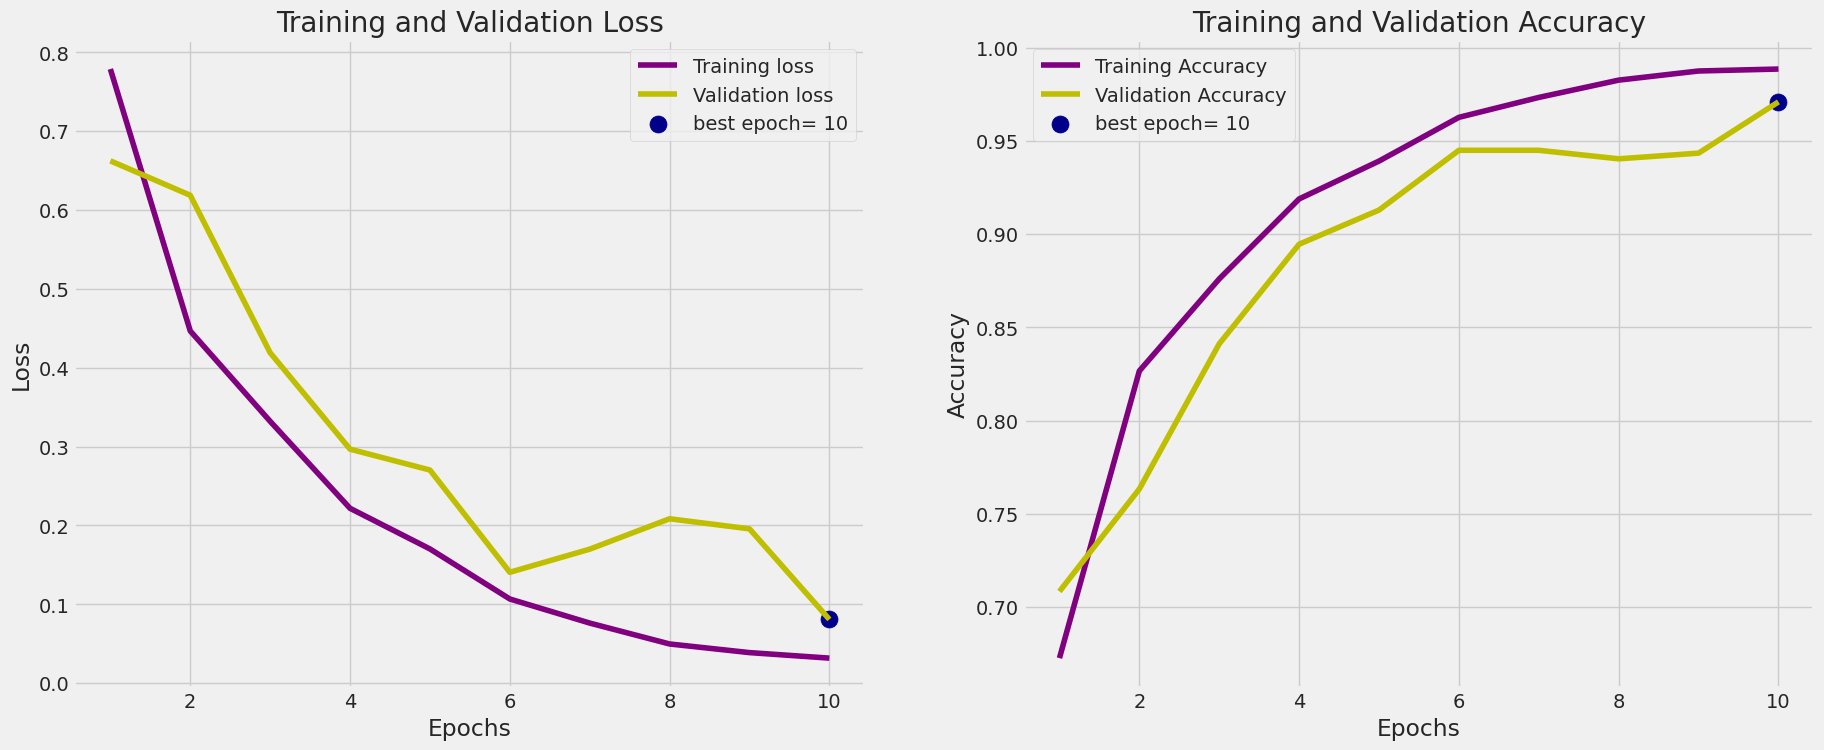

In [47]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'y', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'y', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [48]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.9967 - loss: 0.0135
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9686 - loss: 0.0894
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9710 - loss: 0.0884
Train Loss:  0.014730459079146385
Train Accuracy:  0.9957982897758484
--------------------
Validation Loss:  0.08079763501882553
Validation Accuracy:  0.970992386341095
--------------------
Test Loss:  0.10521675646305084
Test Accuracy:  0.9664633870124817


# **Get Predictions**

In [50]:
pred = model.predict(test_gen)    # [[0.001, 0.97, 0.01, 0.009], [], [], ]
y_pred = np.argmax(pred, axis=1)            # [1, 2, 0, 2, 3]

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


#### **Confusion Matrics and Classification Report**

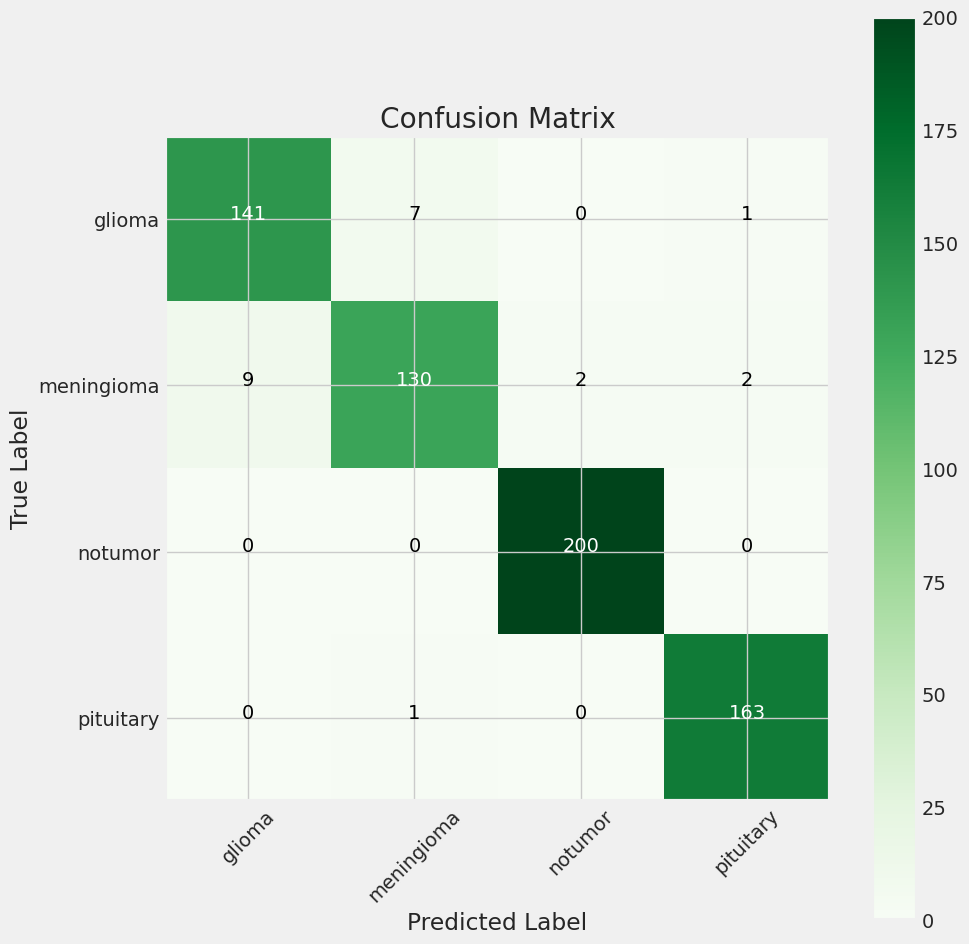

In [54]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [57]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.94      0.95      0.94       149
  meningioma       0.94      0.91      0.93       143
     notumor       0.99      1.00      1.00       200
   pituitary       0.98      0.99      0.99       164

    accuracy                           0.97       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.97      0.97      0.97       656



#### **Save model**

In [58]:
#Save the model
model.save('Brain Tumors.h5')

## **Prediction using loaded_model**

In [59]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Brain Tumors.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= .0001), loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [60]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0007.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
print(f"{class_labels[np.argmax(predictions)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Meningioma
